In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Visualization of brushfire grid, GVD, and paths
def plot_GVD(grid, GVD=None, path=None):
  fig, ax = plt.subplots()
  GVD_grid = np.copy(grid)
  if GVD:
    GVD_x, GVD_y = zip(*GVD)
    GVD_grid[GVD_x,GVD_y] = 20

  img1 = ax.imshow(GVD_grid, cmap="RdBu", alpha=0.6)
  obstacles = GVD_grid.copy()
  obstacles[obstacles < 0] = -2.0
  masked_data = np.ma.masked_where(obstacles > 0, obstacles)
  img2 = ax.imshow(masked_data, cmap="bwr")
  legend_elements = [Patch(facecolor='blue', label='Obstacle')]
  if GVD: legend_elements.append(Patch(facecolor='#83b1d3', label='GVD'))

  if path:
    path_x, path_y = zip(*path)
    GVD_grid[path_x,path_y] = 40.0
    grid_path = GVD_grid.copy()
    grid_path = np.ma.masked_where(grid_path != 40.0, grid_path)
    img3 = ax.imshow(grid_path, cmap="cool_r", interpolation="nearest") 
    legend_elements.append(Patch(facecolor='#e741f6', label='path'))

  ax.legend(handles=legend_elements)
  plt.show()

In [106]:
# Generation of example environments
# Feel free to generate more using these as baseline

def generate_world_1(width=100, height=100):  
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)  

  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 30, 70, 40, 60, -1)

  return grid_world, x_list, y_list


def generate_world_2(width=100, height=100):    
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))  
  grid_world = create_rectangle_obstacle(grid_world, 20, 40, 45, 85, -1)
  
  # triangle obstacle
  for x in range(60, 91):
    for y in range(20, 91-x+21):
      grid_world[int(x), int(y)] = -2

  return grid_world, x_list, y_list


def generate_world_3(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 15, 45, 20, 50, -1)
  grid_world = create_circle_obstacle(grid_world, 75.0, 30.0, 12, -2)
  grid_world = create_circle_obstacle(grid_world, 50.0, 75.0, 16, -3)
  
  return grid_world, x_list, y_list


def generate_world_4(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  grid_world = np.zeros((width, height))

  # triangle obstacle
  for x in range(50, 81):
    for y in range(20, 21+x-50):
      grid_world[int(x), int(y)] = -1

  grid_world = create_rectangle_obstacle(grid_world, 30, 60, 55, 85, -2)
  grid_world = create_circle_obstacle(grid_world, 25.0, 30.0, 12, -3)
  
  return grid_world, x_list, y_list


def create_circle_obstacle(grid_world, center_x, center_y, radius, obst_id):
  c_x, c_y, r_2 = center_x, center_y, radius
  for x in range(grid_world.shape[0]):
    for y in range(grid_world.shape[1]):
      if np.sqrt((x - c_x)**2 + (y - c_y)**2) < r_2:
        grid_world[int(x), int(y)] = obst_id
  return grid_world


def create_rectangle_obstacle(grid_world, lower_x, upper_x, lower_y, upper_y, obst_id):
  grid_world[lower_x: upper_x, lower_y: upper_y] = obst_id
  return grid_world

In [107]:
z_1, _, _ = generate_world_1()
z_2, _, _ = generate_world_2()
z_3, _, _ = generate_world_3()
z_4, _, _ = generate_world_4()

In [108]:
# Utility functions: You may use or modify any of these

# Return valid neighbors on the grid of cell [i,j]
def neighbors(grid, i, j):
  n = []

  if i-1 >= 0:
    n.append((i-1,j))
    if j-1 >= 0: n.append((i-1,j-1))
    if j+1 < grid.shape[1]: n.append((i-1,j+1))
  if i+1 < grid.shape[0]: 
    n.append((i+1,j))
    if j-1 >= 0: n.append((i+1,j-1))
    if j+1 < grid.shape[1]: n.append((i+1,j+1))
  if j-1 >= 0: n.append((i,j-1))
  if j+1 < grid.shape[1]: n.append((i,j+1))

  return n


# Shortest path from any cell in env to a cell in GVD via gradient ascent
def path_to_GVD(grid, GVD, cell):
  path = [cell]
  while path[-1] not in GVD:
    next = path[-1]
    for n in neighbors(grid, path[-1][0], path[-1][1]):
      if grid[n[0], n[1]] > grid[next[0], next[1]]:
        next = n
    path.append(next)
  return path


# Shortest path between two points on GVD
def GVD_path(grid, GVD, A, B):
  GVD = set(GVD)
  closed = set([])
  open = [A]
  pointers = {}

  while len(open) > 0:
    cell = open.pop(0)
    new_neighbors = GVD.intersection(set(neighbors(grid, cell[0], cell[1]))) - closed

    if B in new_neighbors:
      pointers[B] = cell
      path = [B]
      while path[-1] != A:
        next = pointers[path[-1]]
        path.append(next)
      return list(reversed(path))

    open += list(new_neighbors)
    closed.update(new_neighbors)
    pointers.update(dict.fromkeys(list(new_neighbors), cell))

  return None

-1.0


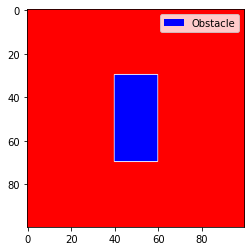

In [109]:
grid_world, x_list, y_list = generate_world_1()
#print(np.matrix(grid_world))
print(grid_world[50][40])
plot_GVD(grid_world)

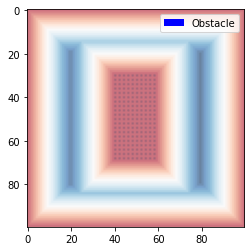

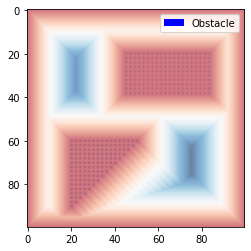

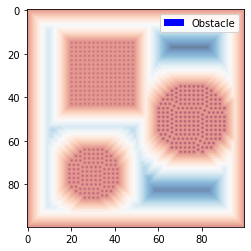

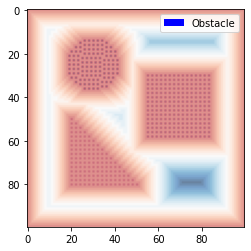

In [110]:
#5.1 Brushfire on a Grid

grid_world1, x_list, y_list = generate_world_1()
grid_world2, x_list, y_list = generate_world_2()
grid_world3, x_list, y_list = generate_world_3()
grid_world4, x_list, y_list = generate_world_4()


#did not realize there was a neighbors() function given to us
def cell_helper(current_cell, grid, queue):
  new_grid = grid
  row, col = current_cell[0], current_cell[1]
  update_val = grid[row][col] + 1
  if 0 <= row+1 < 100 and 0 <= col+1 < 100 and new_grid[row+1][col+1] == 0:
    new_grid[row+1][col+1] = update_val
    cell = (row+1, col+1)
    queue.append(cell)
  if 0 <= row+1 < 100 and 0 <= col < 100 and new_grid[row+1][col] == 0:
    new_grid[row+1][col] = update_val
    cell = (row+1, col)
    queue.append(cell)
  if 0 <= row+1 < 100 and 0 <= col-1 < 100 and new_grid[row+1][col-1] == 0:
    new_grid[row+1][col-1] = update_val
    cell = (row+1, col-1)
    queue.append(cell)
  if 0 <= row < 100 and 0 <= col+1 < 100 and new_grid[row][col+1] == 0:
    new_grid[row][col+1] = update_val
    cell = (row, col+1)
    queue.append(cell)
  if 0 <= row < 100 and 0 <= col-1 < 100 and new_grid[row][col-1] == 0:
    new_grid[row][col-1] = update_val
    cell = (row, col-1)
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col+1 < 100 and new_grid[row-1][col+1] == 0:
    new_grid[row-1][col+1] = update_val
    cell = (row-1, col+1)
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col < 100 and new_grid[row-1][col] == 0:
    new_grid[row-1][col] = update_val
    cell = (row-1, col)
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col-1 < 100 and new_grid[row-1][col-1] == 0:
    new_grid[row-1][col-1] = update_val
    cell = (row-1, col-1)
    queue.append(cell)

  return new_grid, queue
  


def brushfire(grid):
  brushfire_grid = grid
  bfs_queue = []
  for i in range(100):
    for j in range(100):
      if brushfire_grid[i][j] < 0:
        nbs = neighbors(brushfire_grid, i, j)
        for neighbor in nbs:
          brushfire_grid[neighbor[0]][neighbor[1]] = 1
          cell = (neighbor[0], neighbor[1])
          bfs_queue.append(cell)

  for i in range(100):
    if not brushfire_grid[i][0]:
      brushfire_grid[i][0] = 1
      cell = (i, 0)
      bfs_queue.append(cell)
    if not brushfire_grid[i][99]:
      brushfire_grid[i][99] = 1
      cell = (i, 99)
      bfs_queue.append(cell)
  for j in range(100):
    if not brushfire_grid[0][j]:
      brushfire_grid[0][j] = 1
      cell = (0, j)
      bfs_queue.append(cell)
    if not brushfire_grid[99][j]:
      brushfire_grid[99][j] = 1
      cell = (99, j)
      bfs_queue.append(cell)


  while bfs_queue:
    current = bfs_queue.pop(0)
    brushfire_grid, bfs_queue = cell_helper(current, brushfire_grid, bfs_queue)
    
  #print(bfs_queue)
  return brushfire_grid

#print(brushfire(grid_world))
plot_GVD(brushfire(grid_world1))
plot_GVD(brushfire(grid_world2))
plot_GVD(brushfire(grid_world3))
plot_GVD(brushfire(grid_world4))

In [111]:
#5.2 GVD Construction

def cell_helper(current_cell, grid, pointers, gvd, queue):
  row, col = current_cell[0], current_cell[1]
  update_val = grid[row][col] + 1
  if 0 <= row+1 < 100 and 0 <= col+1 < 100 and grid[row+1][col+1] == 0:
    #new_grid[row+1][col+1] = update_val
    cell = (row+1, col+1)
    #if pointers[row+1][col+1] != pointers[row][col]:
    #  gvd.append(cell)
    #else:
    grid[row+1][col+1] = update_val
    pointers[row+1][col+1] = pointers[row][col]
    queue.append(cell)
  if 0 <= row+1 < 100 and 0 <= col < 100 and grid[row+1][col] == 0:
    #new_grid[row+1][col] = update_val
    cell = (row+1, col)
    #if pointers[row+1][col] != pointers[row][col] and grid[row+1][col] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row+1][col] = update_val
    pointers[row+1][col] = pointers[row][col]
    queue.append(cell)
  if 0 <= row+1 < 100 and 0 <= col-1 < 100 and grid[row+1][col-1] == 0:
    #new_grid[row+1][col-1] = update_val
    cell = (row+1, col-1)
    #if pointers[row+1][col-1] != pointers[row][col] and grid[row+1][col-1] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row+1][col-1] = update_val
    pointers[row+1][col-1] = pointers[row][col]
    queue.append(cell)
  if 0 <= row < 100 and 0 <= col+1 < 100 and grid[row][col+1] == 0:
    #new_grid[row][col+1] = update_val
    cell = (row, col+1)
    #if pointers[row][col+1] != pointers[row][col] and grid[row][col+1] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row][col+1] = update_val
    pointers[row][col+1] = pointers[row][col]
    queue.append(cell)
  if 0 <= row < 100 and 0 <= col-1 < 100 and grid[row][col-1] == 0:
    #new_grid[row][col-1] = update_val
    cell = (row, col-1)
    #if pointers[row][col-1] != pointers[row][col] and grid[row][col-1] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row][col-1] = update_val
    pointers[row][col-1] = pointers[row][col]
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col+1 < 100 and grid[row-1][col+1] == 0:
    #new_grid[row-1][col+1] = update_val
    cell = (row-1, col+1)
    #if pointers[row-1][col+1] != pointers[row][col] and grid[row-1][col+1] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row-1][col+1] = update_val
    pointers[row-1][col+1] = pointers[row][col]
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col < 100 and grid[row-1][col] == 0:
    #new_grid[row-1][col] = update_val
    cell = (row-1, col)
    #if pointers[row-1][col] != pointers[row][col] and grid[row-1][col] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row-1][col] = update_val
    pointers[row-1][col] = pointers[row][col]
    queue.append(cell)
  if 0 <= row-1 < 100 and 0 <= col-1 < 100 and grid[row-1][col-1] == 0:
    #new_grid[row-1][col-1] = update_val
    cell = (row-1, col-1)
    #if pointers[row-1][col-1] != pointers[row][col] and grid[row-1][col-1] == update_val:
    #  gvd.append(cell)
    #else:
    grid[row-1][col-1] = update_val
    pointers[row-1][col-1] = pointers[row][col]
    queue.append(cell)

  return grid, queue, pointers, gvd
  


def brushfire(grid):
  brushfire_grid = grid
  bfs_queue = []
  obstacle_num = 0
  gvd = []
  pointer_grid = [[0 for i in range(100)] for j in range(100)]

  for i in range(100):
    for j in range(100):
      if brushfire_grid[i][j] < 0:
        obstacle_num = brushfire_grid[i][j]
        nbs = neighbors(brushfire_grid, i, j)
        for neighbor in nbs:
          brushfire_grid[neighbor[0]][neighbor[1]] = 1
          cell = (neighbor[0], neighbor[1])
          pointer_grid[neighbor[0]][neighbor[1]] = obstacle_num
          bfs_queue.append(cell)

  obstacle_num -= 1
  for i in range(100):
    if not brushfire_grid[i][0]:
      brushfire_grid[i][0] = 1
      pointer_grid[i][0] = obstacle_num
      #first element indicates current cell, 
      #second element indicates origin cell,
      #equal at first
      cell = (i, 0)
      bfs_queue.append(cell)
  obstacle_num -= 1
  for i in range(100):
    if not brushfire_grid[i][99]:
      brushfire_grid[i][99] = 1
      pointer_grid[i][99] = obstacle_num
      cell = (i, 99)
      bfs_queue.append(cell)
  obstacle_num -= 1
  for j in range(100):
    if not brushfire_grid[0][j]:
      brushfire_grid[0][j] = 1
      pointer_grid[0][j] = obstacle_num
      cell = (0, j)
      bfs_queue.append(cell)
  obstacle_num -= 1
  for j in range(100):
    if not brushfire_grid[99][j]:
      brushfire_grid[99][j] = 1
      pointer_grid[99][j] = obstacle_num
      cell = (99, j)
      bfs_queue.append(cell)

  while bfs_queue:
    current = bfs_queue.pop(0)
    brushfire_grid, bfs_queue, pointer_grid, gvd= \
    cell_helper(current, brushfire_grid, pointer_grid, gvd, bfs_queue)

  for i in range(100):
    for j in range(100):
      nbs = neighbors(brushfire_grid, i, j)
      #wave = pointer_grid[i][j]
      diff = set()
      for neighbor in nbs:
        if pointer_grid[neighbor[0]][neighbor[1]] not in diff:
          diff.add(pointer_grid[neighbor[0]][neighbor[1]])
        if len(diff) > 1:
          gvd.append((i, j))
          break


  #print(pointer_grid)
  print(gvd)

  #print(bfs_queue)
  return brushfire_grid, gvd


[(0, 0), (0, 1), (0, 2), (0, 97), (0, 98), (0, 99), (1, 0), (1, 1), (1, 2), (1, 3), (1, 96), (1, 97), (1, 98), (1, 99), (2, 1), (2, 2), (2, 3), (2, 4), (2, 95), (2, 96), (2, 97), (2, 98), (3, 2), (3, 3), (3, 4), (3, 5), (3, 94), (3, 95), (3, 96), (3, 97), (4, 3), (4, 4), (4, 5), (4, 6), (4, 93), (4, 94), (4, 95), (4, 96), (5, 4), (5, 5), (5, 6), (5, 7), (5, 92), (5, 93), (5, 94), (5, 95), (6, 5), (6, 6), (6, 7), (6, 8), (6, 91), (6, 92), (6, 93), (6, 94), (7, 6), (7, 7), (7, 8), (7, 9), (7, 90), (7, 91), (7, 92), (7, 93), (8, 7), (8, 8), (8, 9), (8, 10), (8, 89), (8, 90), (8, 91), (8, 92), (9, 8), (9, 9), (9, 10), (9, 11), (9, 88), (9, 89), (9, 90), (9, 91), (10, 9), (10, 10), (10, 11), (10, 12), (10, 87), (10, 88), (10, 89), (10, 90), (11, 10), (11, 11), (11, 12), (11, 13), (11, 86), (11, 87), (11, 88), (11, 89), (12, 11), (12, 12), (12, 13), (12, 14), (12, 85), (12, 86), (12, 87), (12, 88), (13, 12), (13, 13), (13, 14), (13, 15), (13, 84), (13, 85), (13, 86), (13, 87), (14, 13), (14,

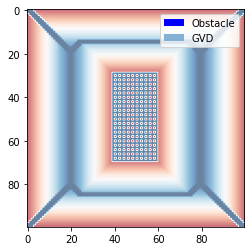

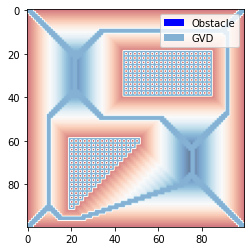

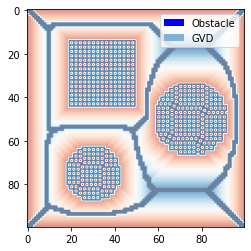

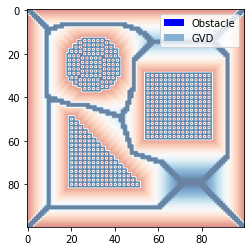

In [112]:
grid_world1, x_list, y_list = generate_world_1()
grid_world2, x_list, y_list = generate_world_2()
grid_world3, x_list, y_list = generate_world_3()
grid_world4, x_list, y_list = generate_world_4()
#print(np.matrix(grid_world))
#plot_GVD(grid_world)


brushfire_grid1, gvd1 = brushfire(grid_world1)
brushfire_grid2, gvd2 = brushfire(grid_world2)
brushfire_grid3, gvd3 = brushfire(grid_world3)
brushfire_grid4, gvd4 = brushfire(grid_world4)
#print(brushfire(grid_world))
plot_GVD(brushfire_grid1, gvd1)
plot_GVD(brushfire_grid2, gvd2)
plot_GVD(brushfire_grid3, gvd3)
plot_GVD(brushfire_grid4, gvd4)

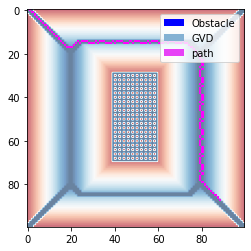

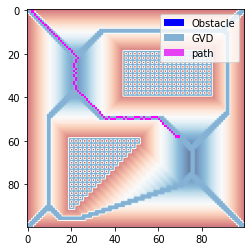

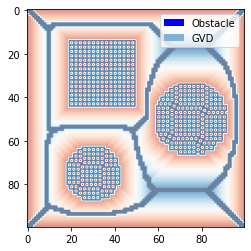

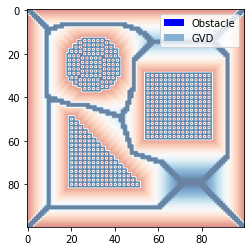

In [120]:
import math

def navigation(grid, gvd, start, goal):
  closest_start = [(gvd[0][0], gvd[0][1]), \
                   math.sqrt(pow(abs(start[0]-gvd[0][0]), 2) + pow(abs(start[1]-gvd[0][1]), 2))]
  closest_goal = [(gvd[0][0], gvd[0][1]), \
                  math.sqrt(pow(abs(goal[0]-gvd[0][0]), 2) + pow(abs(goal[1]-gvd[0][1]), 2))]
  for cell in gvd:
    new_dist_start = math.sqrt(pow(abs(start[0]-cell[0]), 2) + pow(abs(start[1]-cell[1]), 2))
    new_dist_goal = math.sqrt(pow(abs(goal[0]-cell[0]), 2) + pow(abs(goal[1]-cell[1]), 2))
    if new_dist_start < closest_start[1]:
      closest_start[1] = new_dist_start
      closest_start[0] = cell
    if new_dist_goal < closest_goal[1]:
      closest_goal[1] = new_dist_goal
      closest_goal[0] = cell
  #print(closest_start)
  #print(closest_goal)
  nav = [closest_start[0]]
  gvd_nav = GVD_path(brushfire_grid1, gvd1, (80, 90), (20, 40))
  nav.extend(gvd_nav)
  nav.append(closest_goal[0])
  return nav


nav1 = GVD_path(brushfire_grid1, gvd1, (87, 88), (0, 1))
plot_GVD(brushfire_grid1, gvd1, nav1)
nav2 = GVD_path(brushfire_grid2, gvd2, (58, 69), (0, 2))
plot_GVD(brushfire_grid2, gvd2, nav2)
nav3 = GVD_path(brushfire_grid3, gvd3, (13, 62), (34, 74))
plot_GVD(brushfire_grid3, gvd3, nav3)
nav4 = GVD_path(brushfire_grid4, gvd4, (62, 25), (3, 4))
plot_GVD(brushfire_grid4, gvd4, nav4)